In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections
import seaborn as sns
from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from statistics import mean
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

np.set_printoptions(threshold=np.inf)

In [4]:
#Base_model = pd.read_csv('/home/ashwini/AL_2025/code_2025/Input/PCT_without_Mg_Ni_La.csv')
Traning = pd.read_csv('/home/ashwini/AL_2025/code_2025/Input/Mg_Ni_109_re.csv')
Pool = pd.read_csv('/home/ashwini/AL_2025/code_2025/Input/Mg_La_Ni_input.csv')

In [6]:
Traning['composition_final'].unique()

array(['Mg0.8Ni0.2', 'Mg0.9Ni0.1', 'Mg0.67Ni0.33', 'Mg0.92Ni0.08',
       'Mg0.85Ni0.15'], dtype=object)

In [3]:
len(Traning['composition_final'].unique())
len(Base_model['composition_final'].unique())
len(Pool['composition_final'].unique())
print(f'MH-PCTpro:{len(Base_model['composition_final'].unique())}, Training:{len(Traning['composition_final'].unique())},  Test:{len(Pool['composition_final'].unique())}')

MH-PCTpro:119, Training:5,  Test:10


In [4]:
# ALL_X_train =Base_model[cols]
# ALL_y_train =Base_model['H2_W%']
# clf1 = ExtraTreesRegressor(
#             n_estimators=n_estimators,
#             max_depth=depth,
#             min_samples_split=min_split,
#             random_state=0,
#             n_jobs=-1
#         )
# clf1.fit(ALL_X_train, ALL_y_train )


In [22]:
cols=[   'Pressure', 'Temperature', 'Cr', 
       'Mass',  'M-M_Eng', 
       'M-H_Bond',  'formation_H',
        'vol_diff', 'EN.Diff', 
       'Atomic.Size.Diff', 'dSmix']
input_1= Traning[cols]
target= Traning['H2_W%']
in_test =Pool[cols]
ou_test = Pool['H2_W%']

In [23]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------
# Setup
# ----------------------
cols = [
    'Pressure', 'Temperature', 'Density', 'EA', 'MP', 'BP', 'VEC', 'FIE', 
    'TC', 'BM', 'HF', 'MV', 'Mass', 'SH', 'M-M_Eng', 'M-M_Bond', 
    'M-H_Bond', 'M-H_Eng', 'EN.Diff', 'M-H.EN.Diff', 
    'Atomic.Size.Diff', 'dSmix'
]

X_train, y_train = Traning[cols], Traning['H2_W%']
X_test, y_test   = Pool[cols], Pool['H2_W%']

# Results containers
n_queries = 5
n_estimators = 100
depth = 10
min_split = 4
n_iterations = 100

Err1 = pd.DataFrame(columns=['MAE_train', 'MAE_test', 'R2_Score'])
Pre1 = Pool[['Sr No', 'composition_final', 'Temperature']].copy()
# Pre1['Prediction_all']= clf1.predict(in_test)
# ----------------------
# Active Learning Loop
# ----------------------
TEST=Pool.copy()
for q in range(n_queries):
   
    predictions = np.zeros((n_iterations, X_test.shape[0]))
    mae_test, mae_train, scores = [], [], []
    
    
    # Train multiple models with different random seeds
    for seed in range(n_iterations):
        clf = ExtraTreesRegressor(
            n_estimators=n_estimators,
            max_depth=depth,
            min_samples_split=min_split,
            random_state=seed,
            n_jobs=-1
        )
        clf.fit(X_train, y_train)

        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        
        X_test_T = TEST[cols] 
        y_test_T = TEST['H2_W%']

        predictions[seed] = y_pred_test
        mae_test.append(mean_absolute_error(y_test_T, clf.predict(X_test_T)))
        mae_train.append(mean_absolute_error(y_train, y_pred_train))
        scores.append(clf.score(X_test_T, y_test_T))

    # Aggregate predictions
    
    mean_pred = predictions.mean(axis=0).round(4)
    std_pred  = predictions.std(axis=0).round(4)

    MAE_test, MAE_train,R2_score = np.mean(mae_test).round(4), np.mean(mae_train).round(4),np.mean(scores).round(4)
    print(MAE_test, MAE_train, R2_score)

    # Store errors
    Err1.loc[q] = [MAE_train, MAE_test, R2_score]

    # Store predictions
    
    Pre1[f'Prediction{q}'] = mean_pred
    Pre1[f'Std{q}'] = std_pred

    # ----------------------
    # Find next sample to add (active learning)
    # ----------------------
    dff = Pool.copy()
    dff['std'] = std_pred
    dff['mean_ML'] = mean_pred
    dff['diff'] = (y_test - dff['mean_ML']).abs()

    # Find (Composition, Temperature) with max uncertainty
    agg_std = (
        dff.groupby(['composition_final', 'Temperature'])['std']
        .sum()
        .reset_index()
    )
    fin_val = agg_std.loc[agg_std['std'].idxmax()]
    print(fin_val.values)

    # Select rows matching that (Composition, Temperature)
    out_df = dff[
        (dff["composition_final"] == fin_val["composition_final"])
    ]

    # Add uncertain sample to training set
    X_train = pd.concat([X_train, out_df[cols]])
    y_train = pd.concat([y_train, out_df['H2_W%']])
    TEST = TEST.drop(out_df.index)

1.2393 0.1596 -0.3911
['La0.01Mg0.92Ni0.06' 553 11.3715]
1.2179 0.2265 -0.5342
['La0.17Mg0.63Ni0.2' 588 13.0262]
0.7868 0.1663 0.3441
['La0.03Mg0.82Ni0.15' 553 9.6062]
0.833 0.1479 0.2786
['La0.02Mg0.87Ni0.1' 623 8.829]
0.8587 0.1632 0.0749
['La0.17Mg0.04Ni0.8' 343 4.7085]


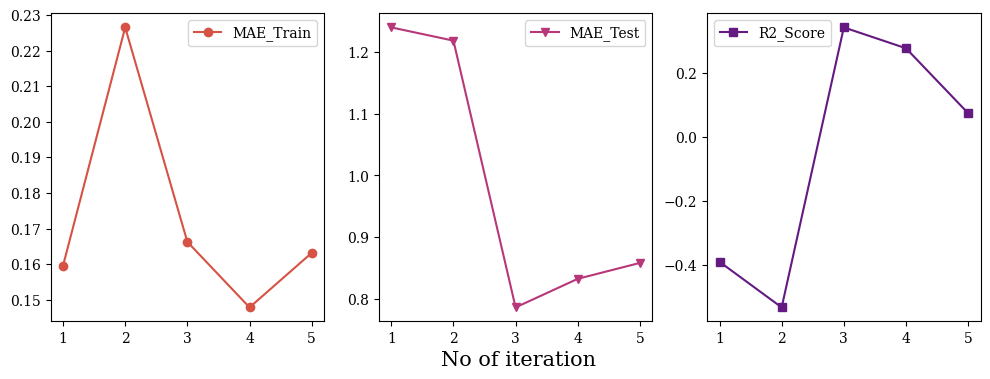

In [25]:
Pre1

fig, (ax1, ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(12, 4))
ax1.plot(Err1.index+1, Err1['MAE_train'],marker = 'o',color=plt.cm.coolwarm(0.9),label='MAE_Train')

ax2.plot(Err1.index+1, Err1['MAE_test'],marker = 'v',color=plt.cm.magma(0.5),label='MAE_Test')
ax3.plot(Err1.index+1, Err1['R2_Score'],marker = 's',color=plt.cm.magma(0.3),label='R2_Score')
#plt.xlabel('No of iteration')
fig.text(0.45,0.001,'No of iteration',fontsize=15)
ax1.legend()
ax2.legend()
ax3.legend()


In [26]:
Pre1['Pressure']=Pool['Pressure']
Pre1['H2_W%']=Pool['H2_W%']
#Pre1['PRE_all']= clf1.predict(in_test)

In [27]:
Pre1

,Sr No,composition_final,Temperature,Prediction0,Std0,Prediction1,Std1,Prediction2,Std2,Prediction3,Std3,Prediction4,Std4,Pressure,H2_W%
0,1,La0.25Mg0.5Ni0.25,584,0.0762,0.0037,0.0738,0.0067,0.1995,0.0079,0.1860,0.0086,0.1819,0.0085,0.018394,0.198599
1,1,La0.25Mg0.5Ni0.25,584,0.0766,0.0037,0.0742,0.0069,0.1996,0.0080,0.1871,0.0087,0.1830,0.0085,0.020203,0.205517
2,1,La0.25Mg0.5Ni0.25,584,0.0777,0.0037,0.0749,0.0072,0.1998,0.0080,0.1886,0.0086,0.1843,0.0083,0.022197,0.211762
3,1,La0.25Mg0.5Ni0.25,584,0.0788,0.0038,0.0756,0.0074,0.2000,0.0080,0.1901,0.0084,0.1856,0.0086,0.024410,0.218008
4,1,La0.25Mg0.5Ni0.25,584,0.0800,0.0037,0.0771,0.0084,0.2004,0.0079,0.1919,0.0082,0.1874,0.0086,0.026846,0.224255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2544,27,La0.05Mg0.8Ni0.15,633,2.6738,0.0899,3.6810,0.1547,2.9872,0.1387,3.7827,0.0453,3.8119,0.0407,2.142501,4.651083
2545,27,La0.05Mg0.8Ni0.15,633,4.0172,0.0690,4.3275,0.0852,4.0163,0.0847,3.8532,0.0442,3.8413,0.0354,2.372565,4.697315
2546,27,La0.05Mg0.8Ni0.15,633,4.2690,0.0602,4.4572,0.0707,4.2840,0.0715,3.8767,0.0494,3.8493,0.0371,2.628810,4.743548
2547,27,La0.05Mg0.8Ni0.15,633,4.3298,0.0686,4.4663,0.0661,4.4173,0.0781,3.9291,0.0515,3.8820,0.0409,2.912185,4.789780


In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

def plot_predictions(Pre1, max_iter=5):
    """Plot experimental vs ML predictions for each Sr_no."""
    plt.rcParams['font.family'] = 'Serif'

    # Get prediction columns dynamically
    prediction_cols = [col for col in Pre1.columns if col.startswith("Prediction")]
    prediction_cols = prediction_cols[:max_iter]

    for sr_no, aa in Pre1.groupby("Sr No"):
        fig, ax = plt.subplots(figsize=(12, 6))

        # Experimental
        ax.plot(
            aa["H2_W%"], aa["Pressure"],
            "ws", ms=10, markeredgecolor="black",
            label="Experimental"
        )
    #    ax.plot(aa["PRE_all"], aa["Pressure"],label="ALL")

        # Predictions
        for i, col in enumerate(prediction_cols):
            ax.plot(
                aa[col], aa["Pressure"], "o", ms=10,
                label=f"{i}th iteration"
            )

        # Formatting
        ax.set_yscale("log")
        ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=3))
        ax.set_xlabel("H2_wt%", fontsize=20)
        ax.set_ylabel("Pressure (MP)", fontsize=20)
        ax.tick_params(axis="both", labelsize=20)
        ax.legend(fontsize=16)

        title = f"{aa.iloc[0]['composition_final']} : {aa.iloc[0]['Temperature']} K"
        ax.set_title(title, fontsize=20)

        plt.show()


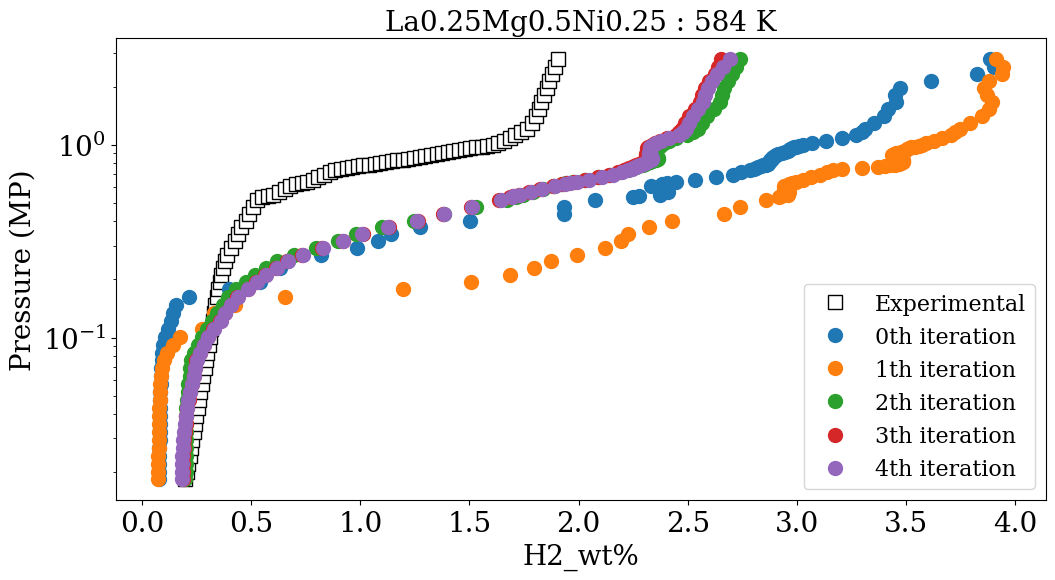

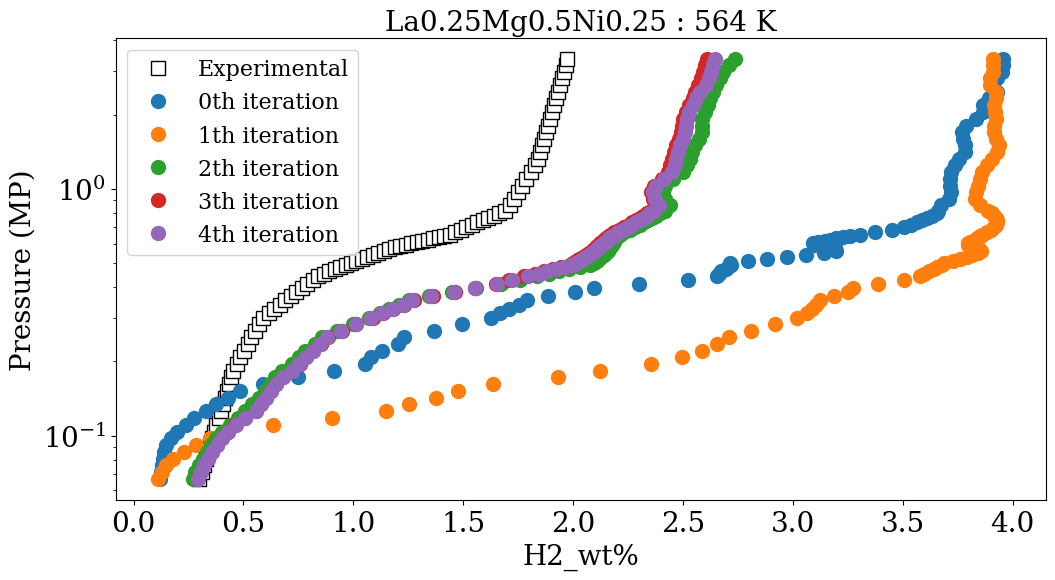

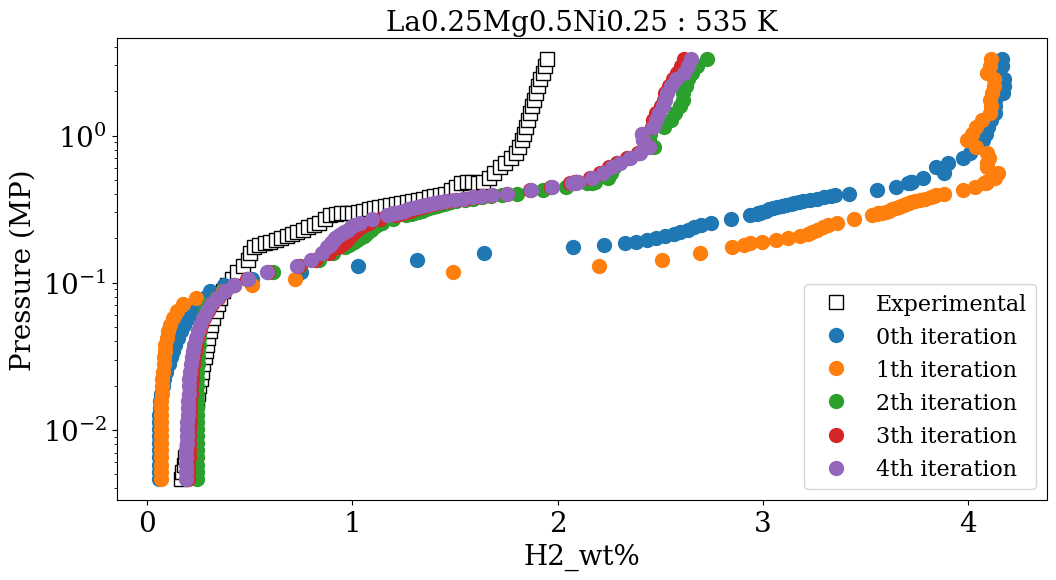

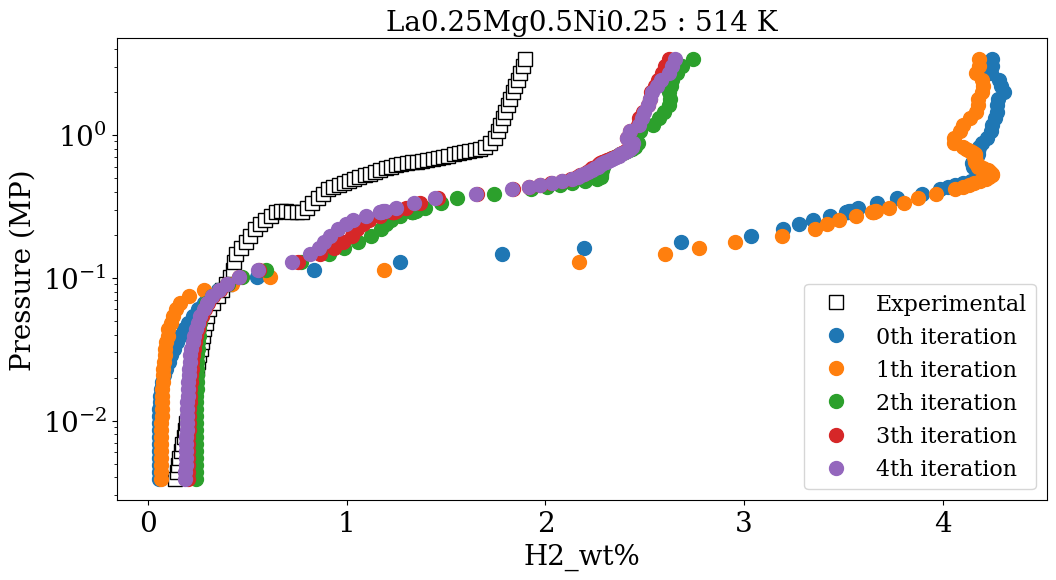

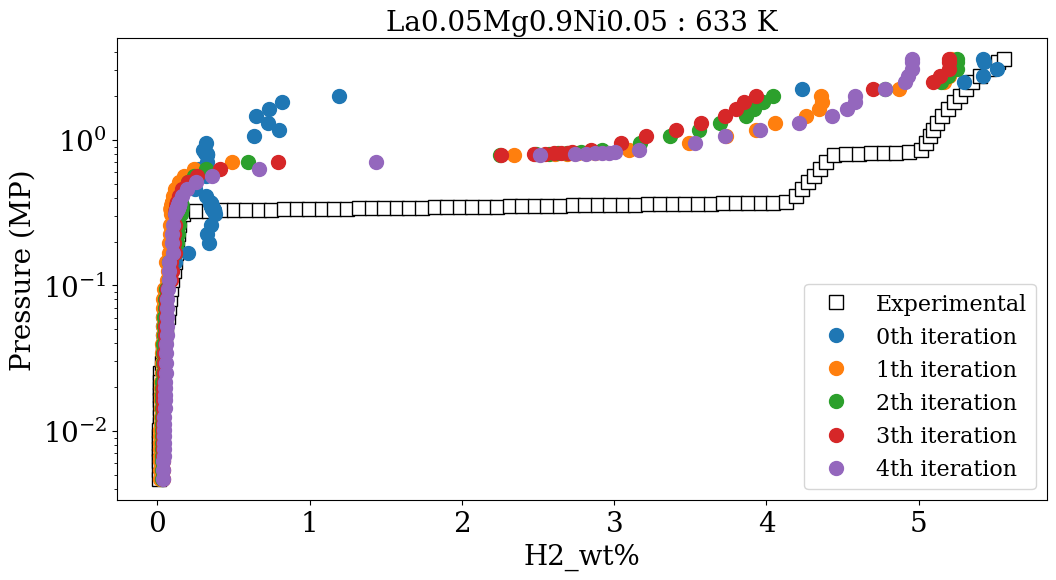

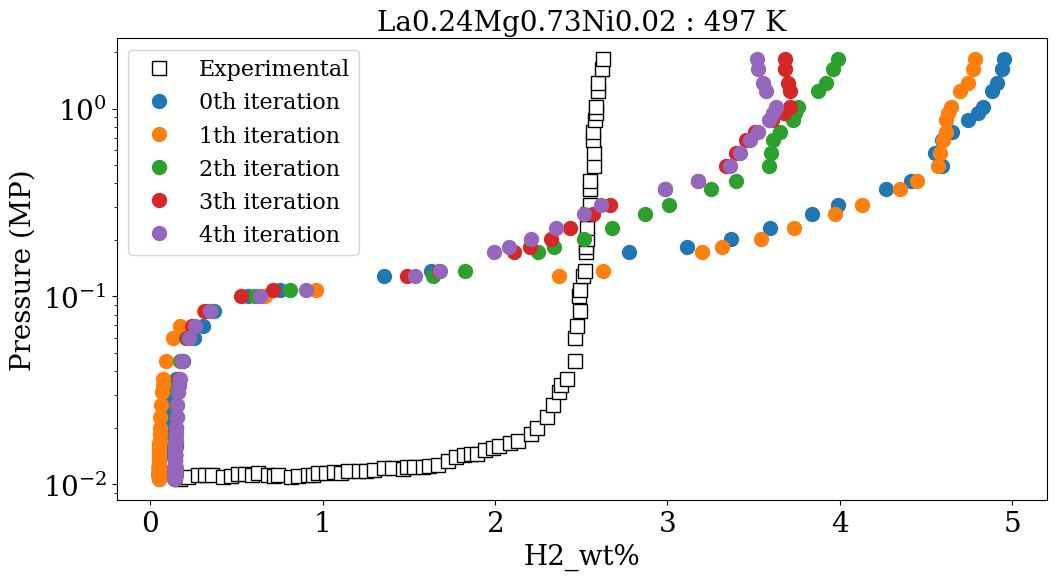

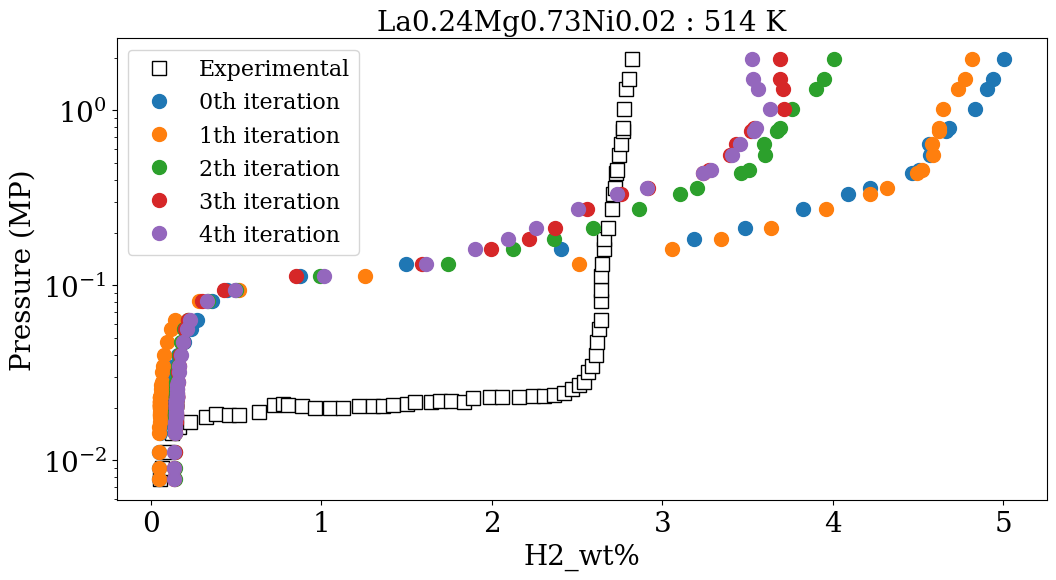

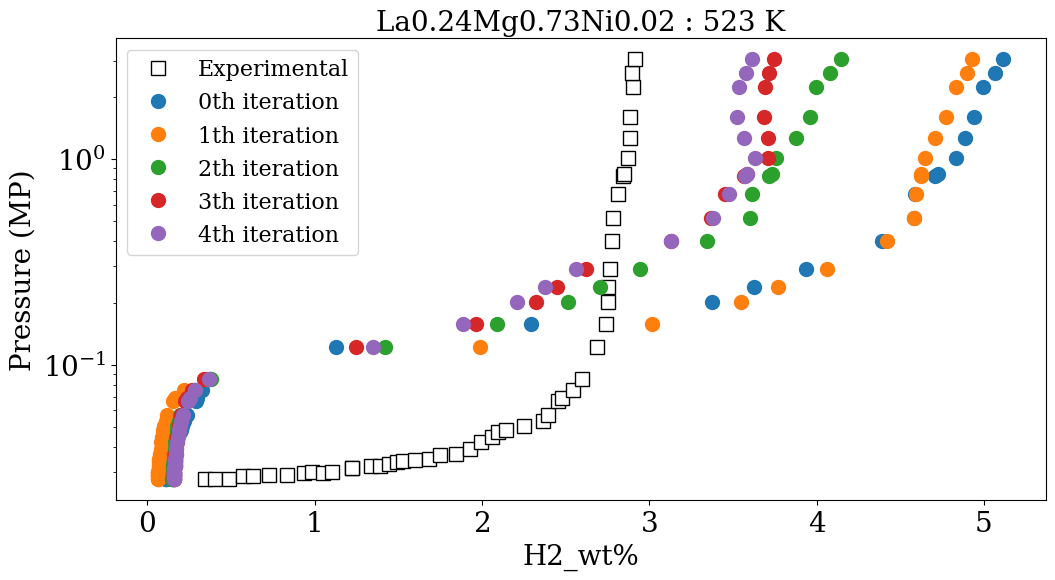

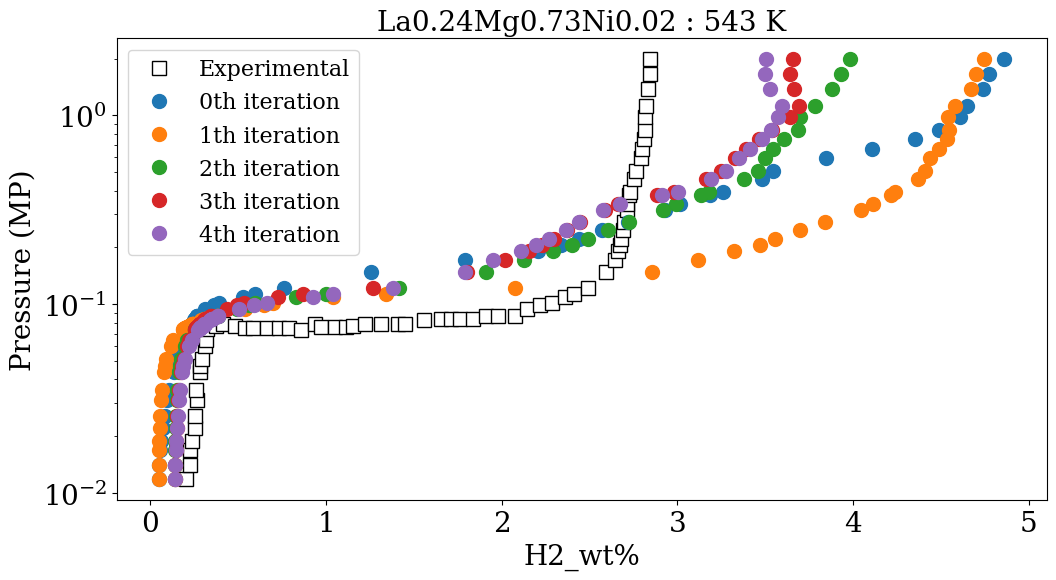

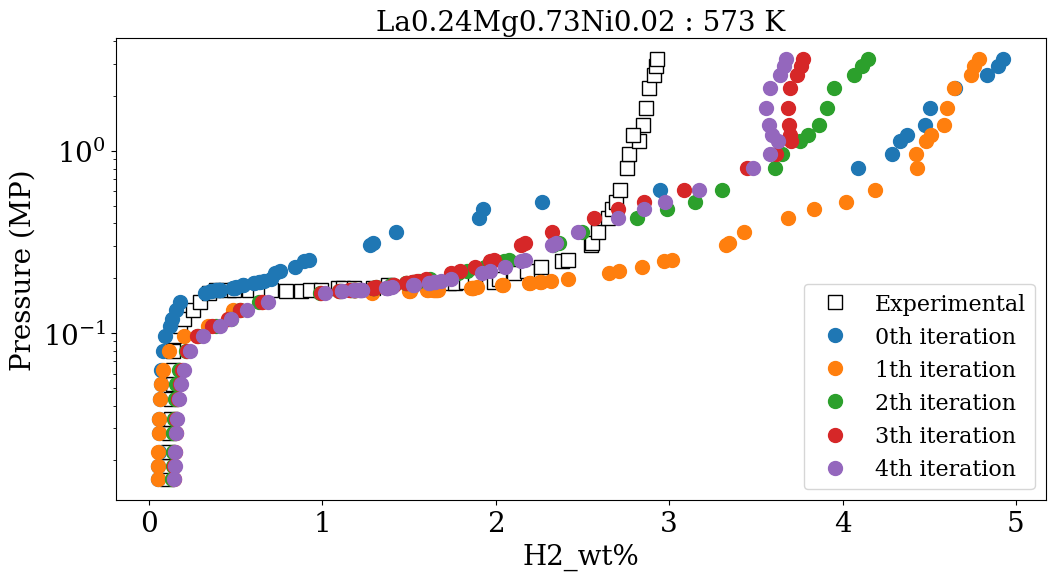

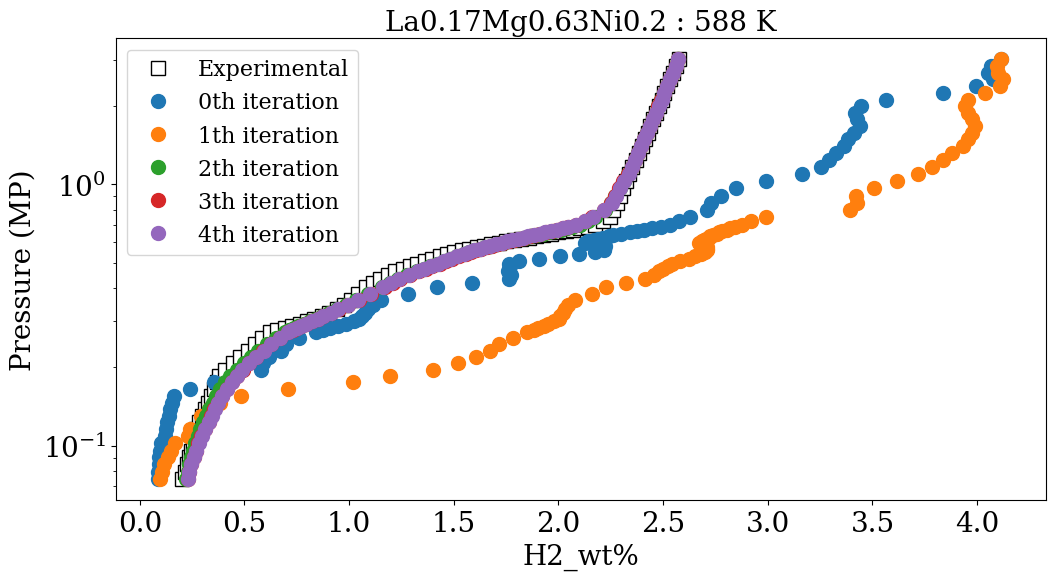

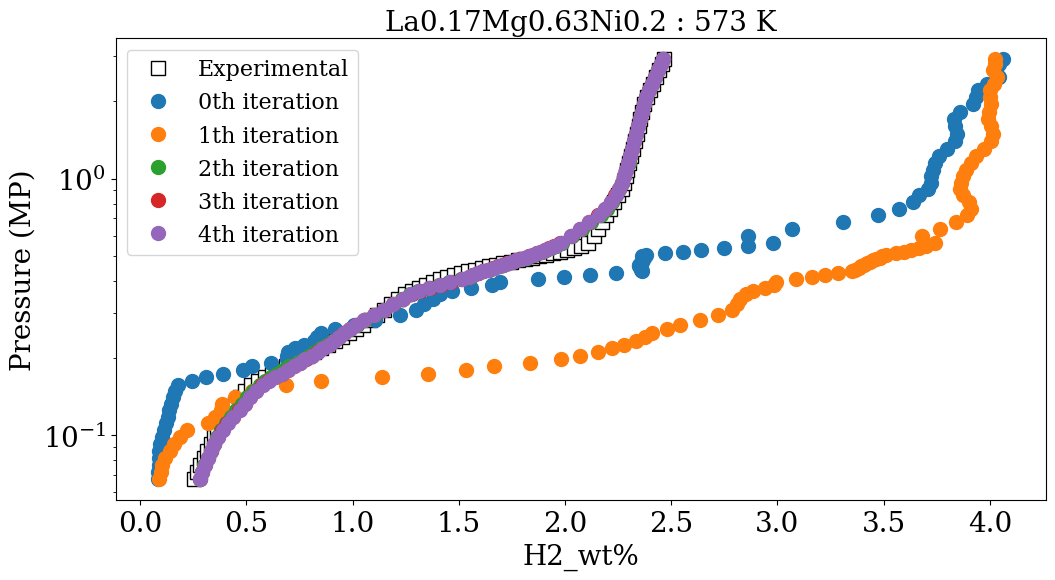

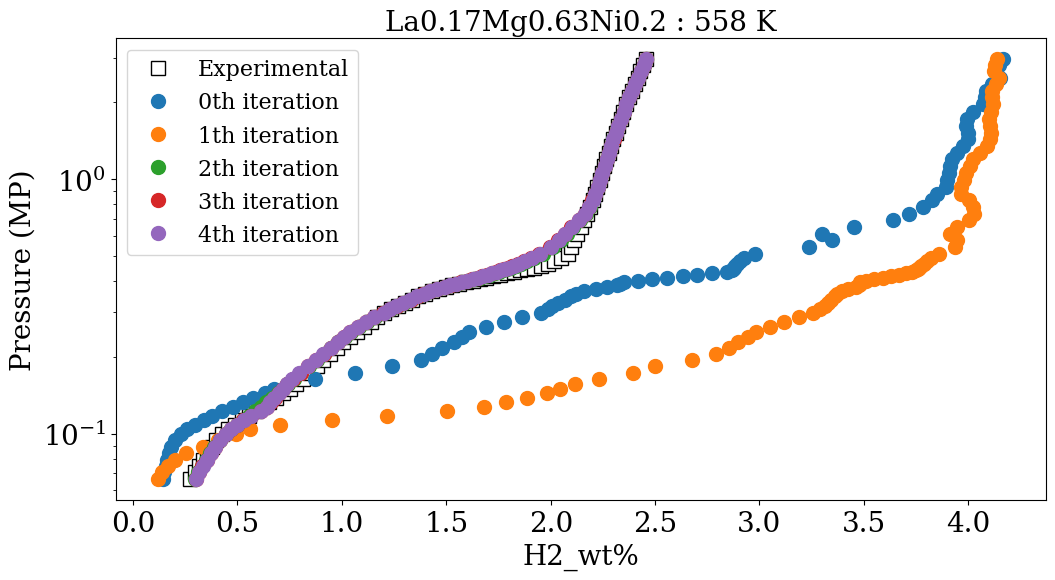

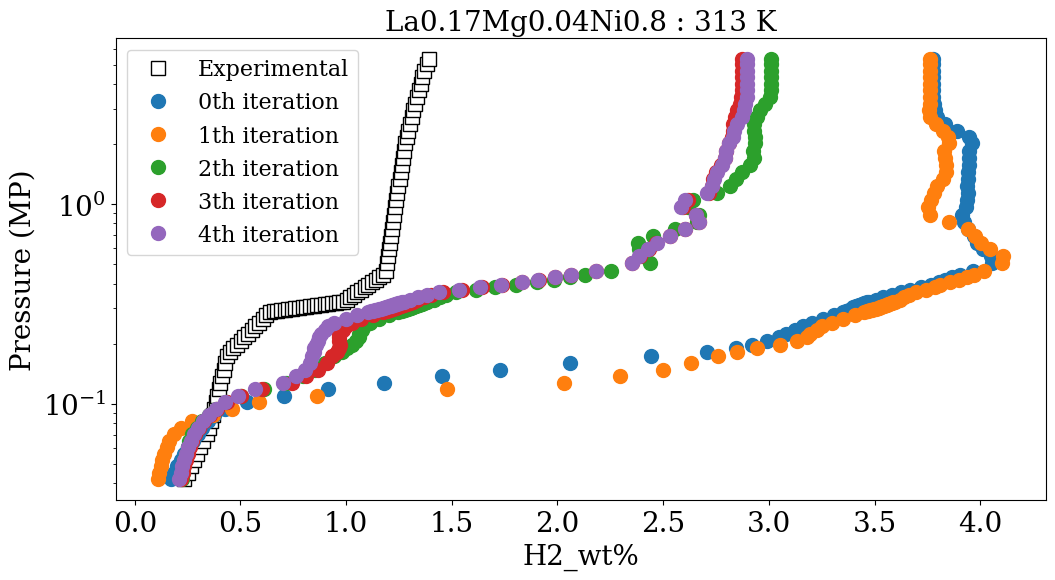

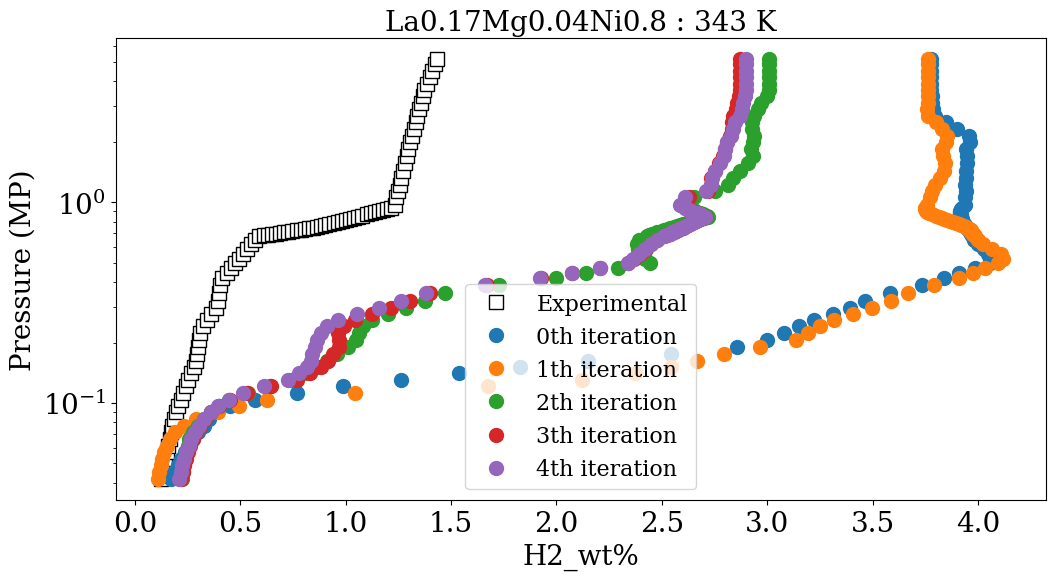

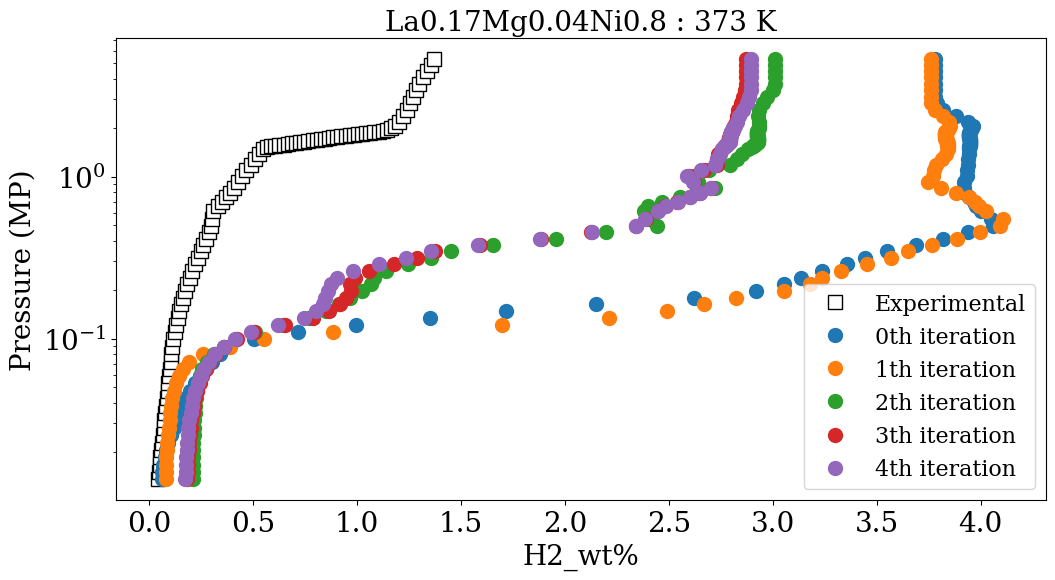

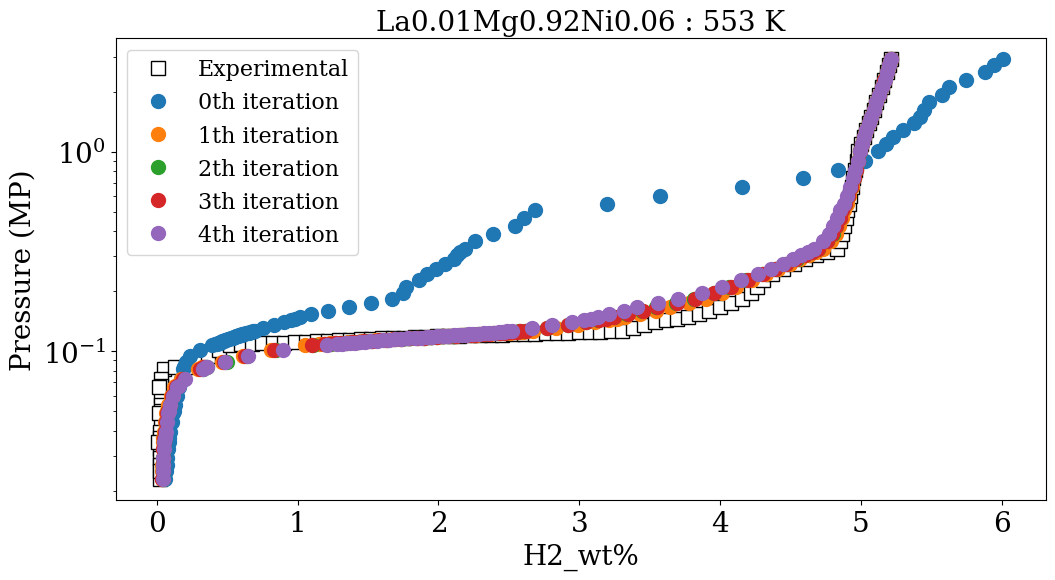

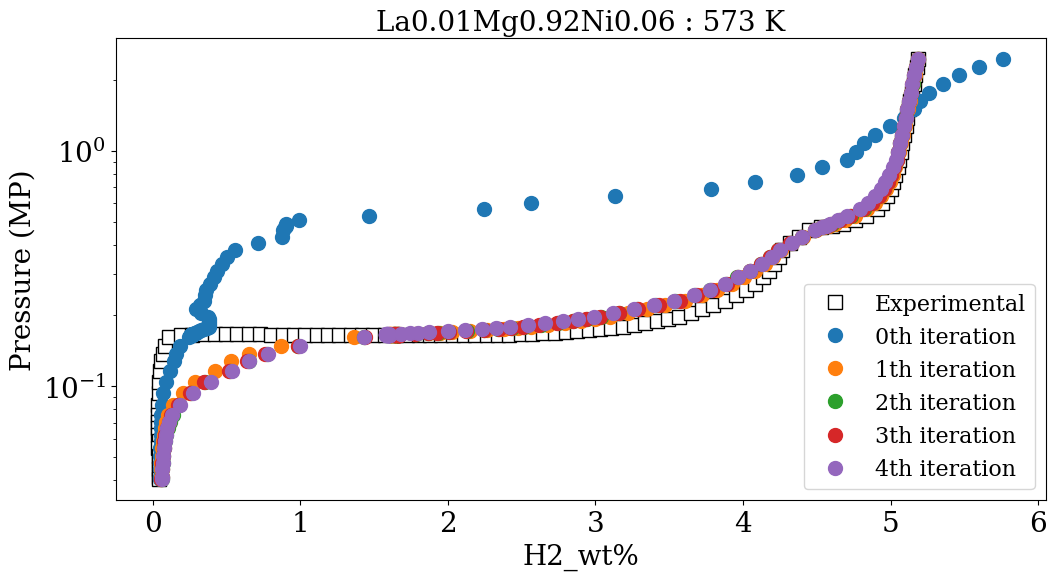

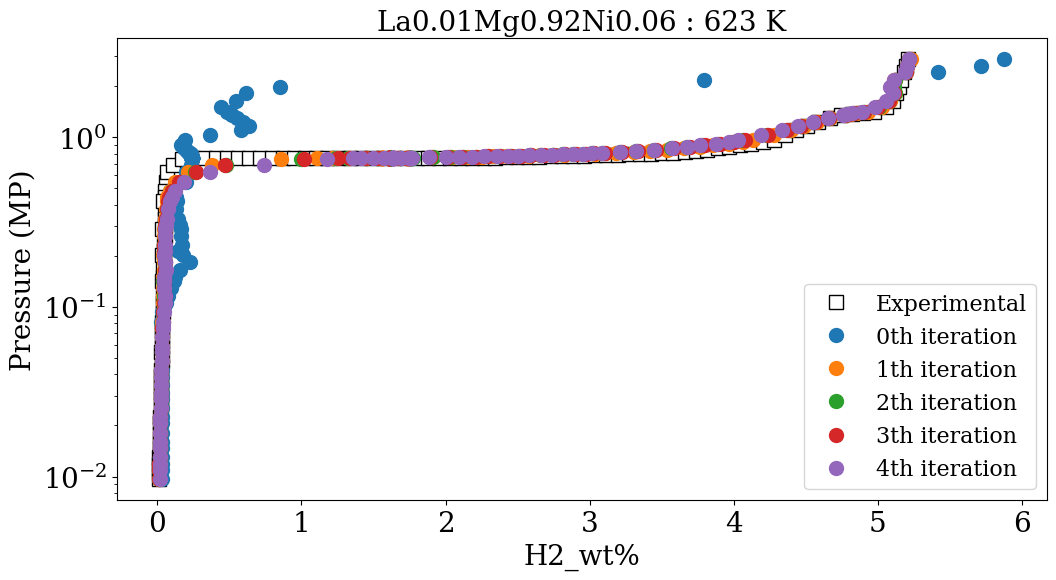

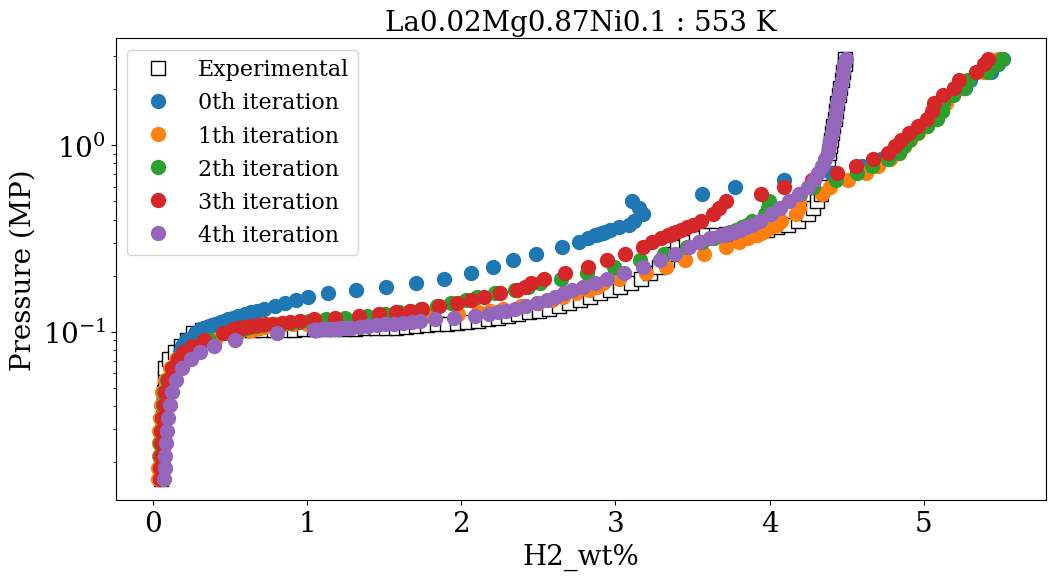

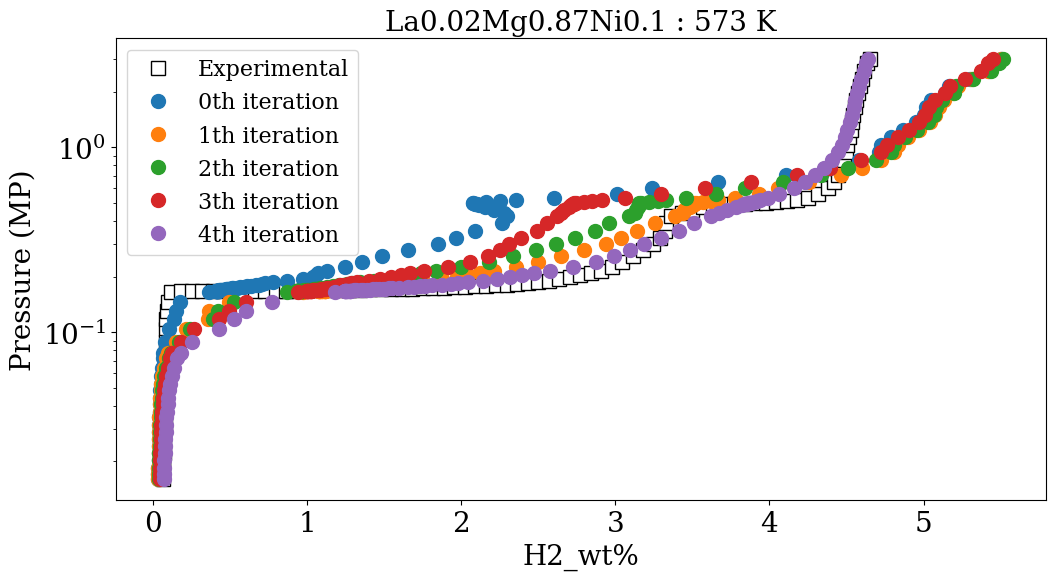

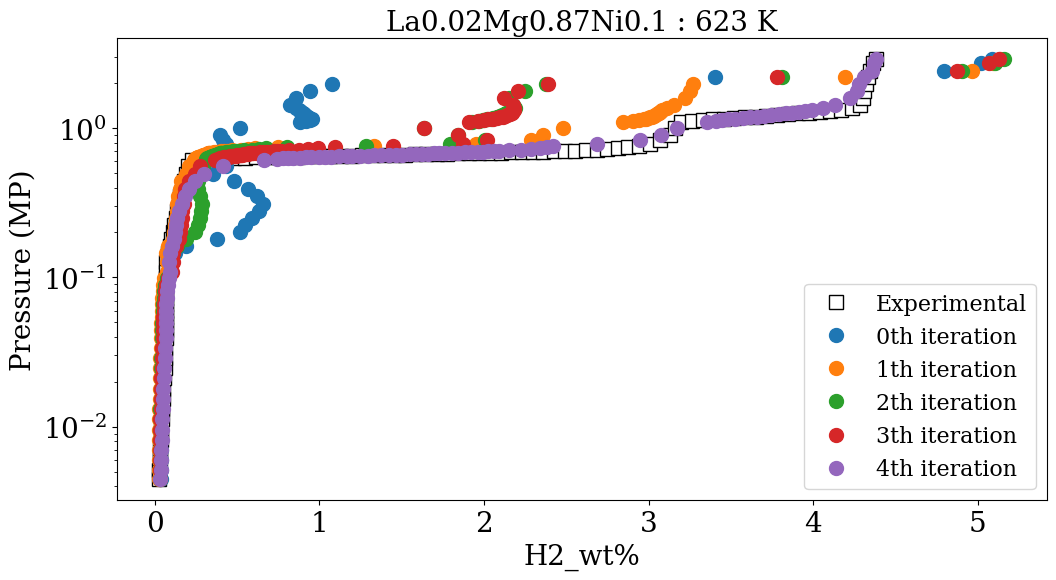

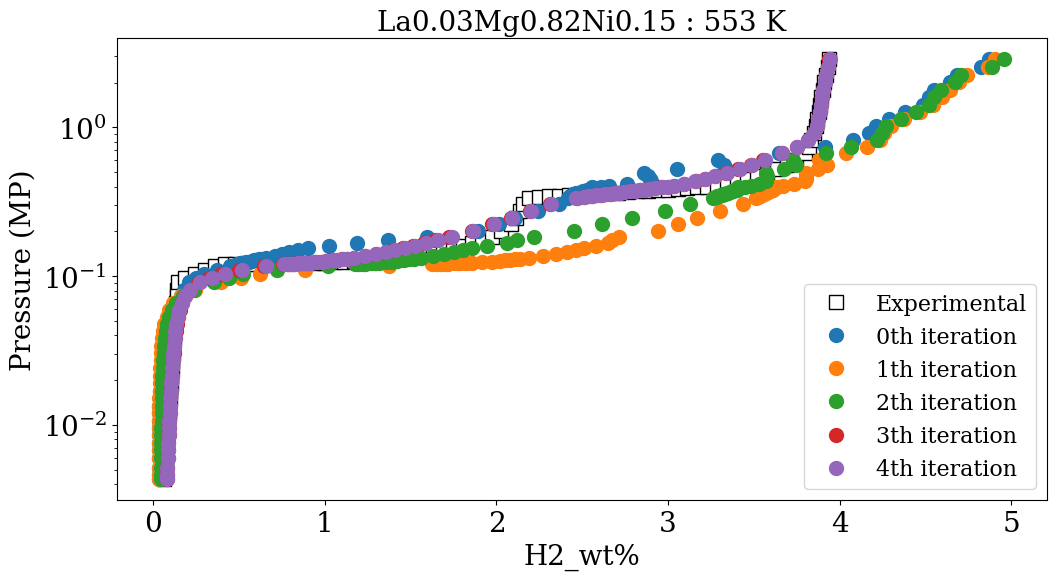

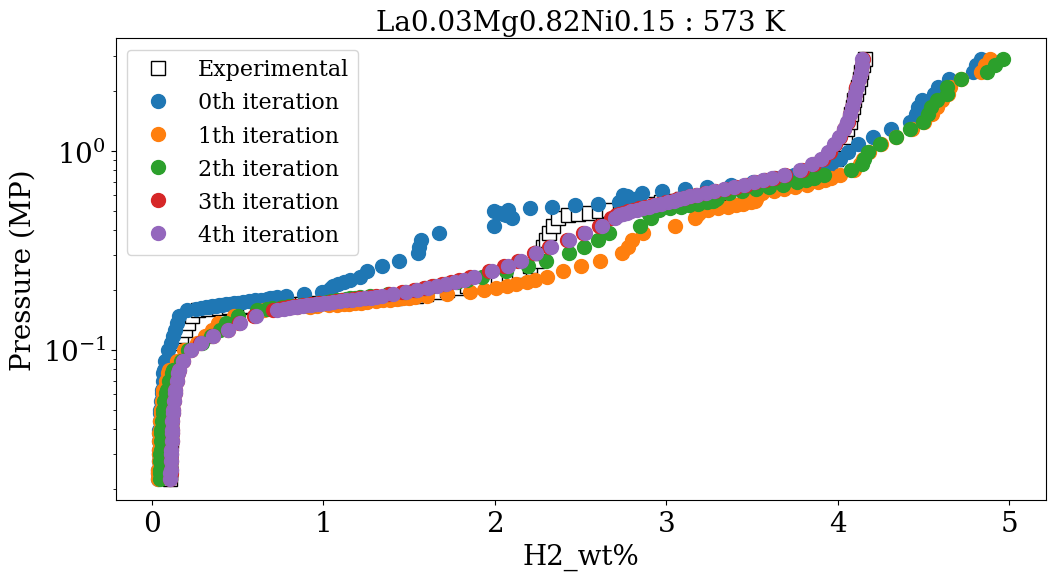

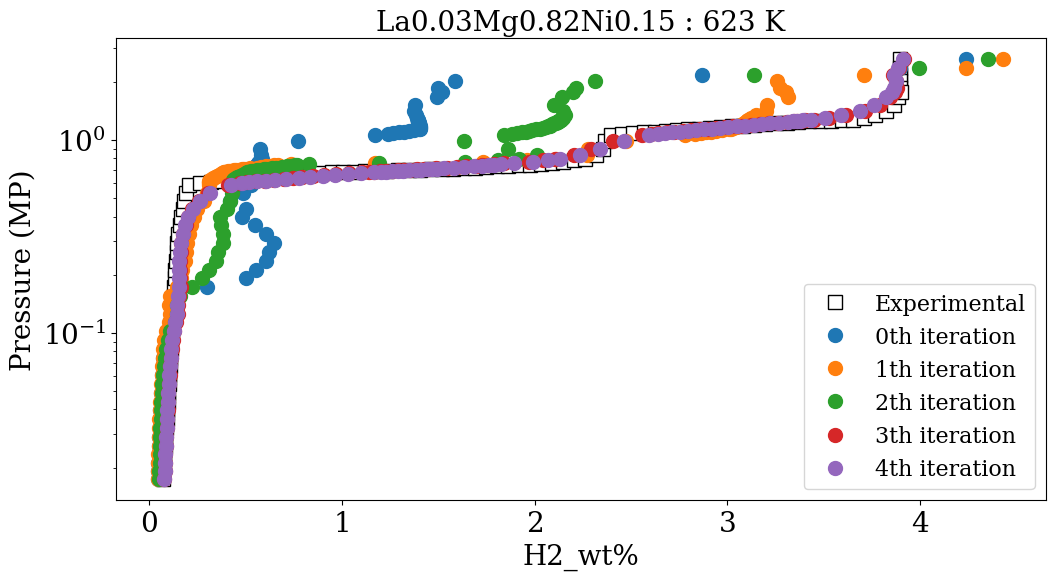

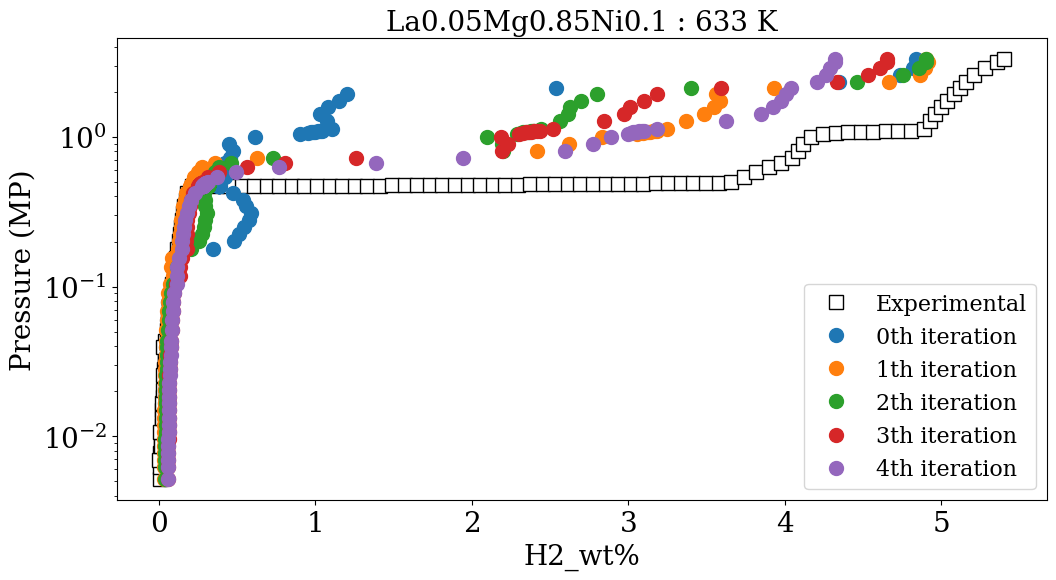

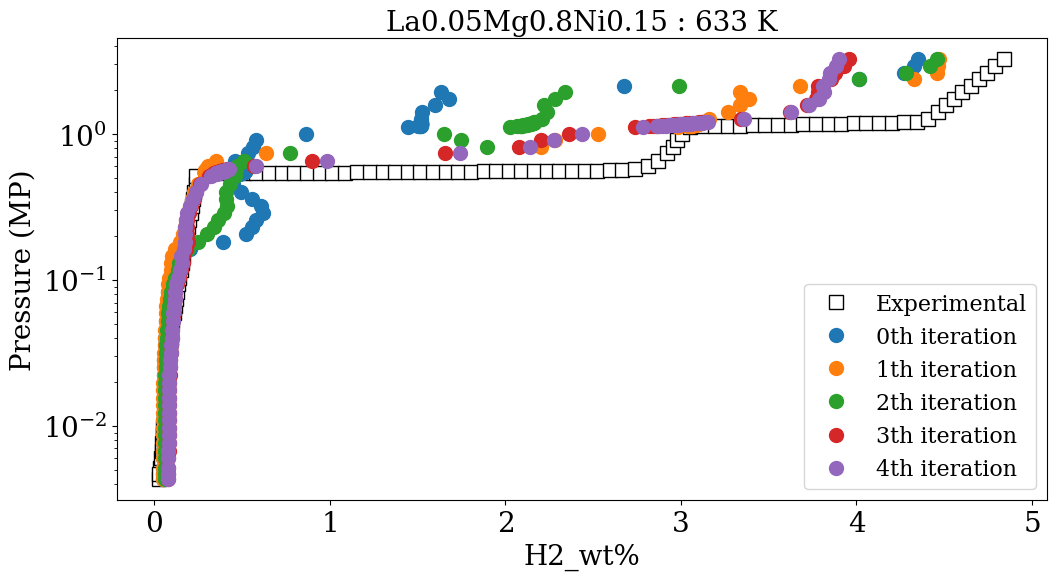

In [29]:

#Pre1
plot_predictions(Pre1, max_iter=5)
#plot_predictions(Pre1)

In [31]:
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------
# Setup
# ----------------------
cols=[   'Pressure', 'Temperature', 'Cr', 
       'Mass',  'M-M_Eng', 
       'M-H_Bond',  'formation_H',
        'vol_diff', 'EN.Diff', 
       'Atomic.Size.Diff', 'dSmix']

X_train, y_train = Traning[cols], Traning['H2_W%']
X_test, y_test   = Pool[cols], Pool['H2_W%']
inp, target      = Pool[cols], Pool['H2_W%']

n_queries   = 5
n_iterations = 100

Err3 = pd.DataFrame(columns=['MAE_test', 'MAE_train', 'R2_Score'])
Pre2 = Pool[['Sr No', 'Composition', 'Temperature', 'Pressure', 'H2_W%']].copy()
TEST = Pool.copy()
# ----------------------
# Active Learning Loop
# ----------------------
for q in range(n_queries):
    predictions_test = np.zeros((n_iterations, X_test.shape[0]))
    predictions_inp  = np.zeros((n_iterations, inp.shape[0]))
    mae_test, mae_train, scores = [], [], []

    # Train multiple models
    for seed in range(n_iterations):
        clf = ExtraTreesRegressor(
            n_estimators=100, max_depth=10, min_samples_split=4,
            random_state=seed, n_jobs=-1
        )
        clf.fit(X_train, y_train)

        y_pred_test = clf.predict(X_test)
        y_pred_inp  = clf.predict(inp)
        y_pred_train = clf.predict(X_train)

        predictions_test[seed] = y_pred_test
        predictions_inp[seed]  = y_pred_inp

        mae_test.append(mean_absolute_error(y_test, y_pred_test))
        mae_train.append(mean_absolute_error(y_train, y_pred_train))
        scores.append(clf.score(X_test, y_test))

    # Aggregate metrics
    mean_pred_inp = predictions_inp.mean(axis=0).round(4)
    std_pred_inp  = predictions_inp.std(axis=0).round(4)

    MAE_test  = np.mean(mae_test).round(4)
    MAE_train = np.mean(mae_train).round(4)
    R2_score  = np.mean(scores).round(4)

    print(f"Query {q}: MAE_test={MAE_test}, MAE_train={MAE_train}, R2={R2_score}")
    print(X_test.shape)
    # Store results
    Err3.loc[q] = [MAE_test, MAE_train, R2_score]
    Pre2[f'Prediction{q}'] = mean_pred_inp
    Pre2[f'Std{q}'] = std_pred_inp

    # ----------------------
    # Randomly select one (Composition, Temperature) group to add to training
    # ----------------------
    comp_choice = random.choice(TEST["Composition"].unique())
#     temp_choice = random.choice(
#         TEST.loc[TEST["Composition"] == comp_choice].unique()
#     )

    print(f"Adding Composition={comp_choice}")

    out_df  = Pool[(Pool["Composition"] == comp_choice)]
    out_X, out_y = out_df[cols], out_df['H2_W%']

    # Move selected rows from test → train
    X_train = pd.concat([X_train, out_X])
    y_train = pd.concat([y_train, out_y])
    X_test  = X_test.drop(out_X.index)
    y_test  = y_test.drop(out_y.index)
    TEST = TEST.drop(out_y.index)


Query 0: MAE_test=1.2824, MAE_train=0.1638, R2=-0.4899
(2549, 11)
Adding Composition=Mg3 La Ni0.1
Query 1: MAE_test=1.0639, MAE_train=0.1893, R2=0.0625
(2228, 11)
Adding Composition=60 Mg – 12.96 La - 27.04 Ni
Query 2: MAE_test=1.1127, MAE_train=0.165, R2=0.0671
(1907, 11)
Adding Composition=80 Mg - 6.48 La - 13.52 Ni
Query 3: MAE_test=0.9792, MAE_train=0.2114, R2=0.0951
(1584, 11)
Adding Composition=La Mg3.70 Ni1.18
Query 4: MAE_test=0.8279, MAE_train=0.1849, R2=0.3799
(1314, 11)
Adding Composition=La 0.81 Mg 0.19 Ni 3.9


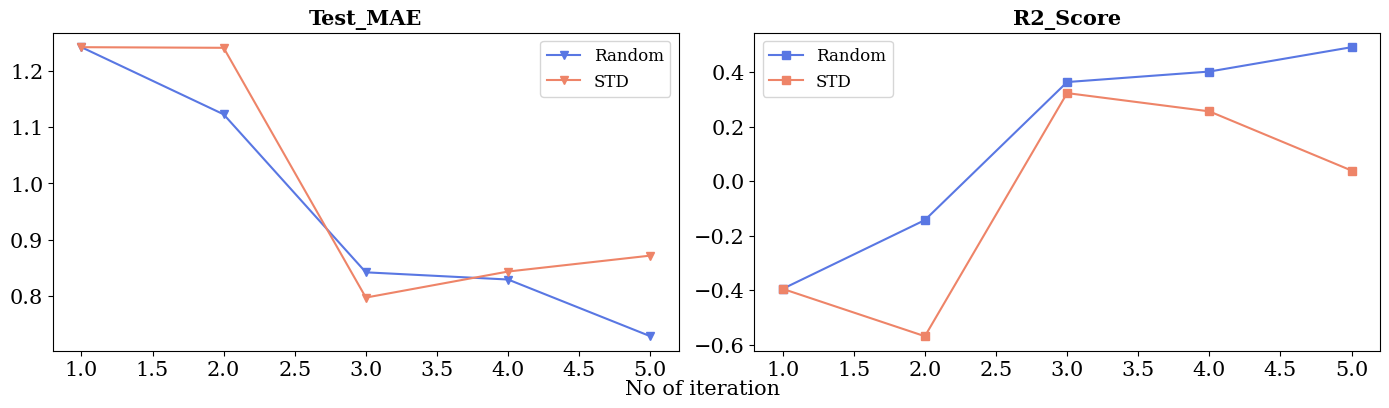

In [15]:
import matplotlib.pyplot as plt

# Create 2 subplots side by side
fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(14, 4))

# Apply tick params once
for ax in (ax2, ax3):
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

# --- Plot Random (Err3) ---
ax2.plot(Err3.index + 1, Err3['MAE_test'], marker='v',
         color=plt.cm.coolwarm(0.1), label='Random')
ax3.plot(Err3.index + 1, Err3['R2_Score'], marker='s',
         color=plt.cm.coolwarm(0.1), label='Random')

# --- Plot STD (Err1) ---
ax2.plot(Err1.index + 1, Err1['MAE_test'], marker='v',
         color=plt.cm.coolwarm(0.8), label='STD')
ax3.plot(Err1.index + 1, Err1['R2_Score'], marker='s',
         color=plt.cm.coolwarm(0.8), label='STD')

# Shared X-label
fig.text(0.45, 0.001, 'No of iteration', fontsize=15)

# Titles
ax2.set_title("Test_MAE", fontweight="bold", size=15)
ax3.set_title("R2_Score", fontweight="bold", size=15)

# Legends
ax2.legend(fontsize=12)
ax3.legend(fontsize=12)

plt.tight_layout()
plt.show()
# plt.savefig('Error.png', format='png', dpi=300, bbox_inches='tight')
